In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as patches
from PIL import Image
from collections import Counter
import numpy as np
from wordcloud import WordCloud, ImageColorGenerator
import squarify
import seaborn as sns

# Dataset

## Produzione di energia elettrica

I dati sulla produzione di energia elettrica sono tratti dal sito web della BP sezione “Energy economics; Statistical review of world energy”.
https://www.bp.com/en/global/corporate/energy-economics/statistical-review-of-world-energy.html

### Pulizia del dataset

Il dataset viene filtrato prendendo in considerazione solo le colonne relative alla produzione di energia elettrica ed eliminando le somme parziali (che nel dataset sono quelle righe in cui 'Country' contiene la parola 'Total', per esempio 'Total Europa', 'Total Africa', ecc...). Dopo di che vengono presi i dati a partire dal 1985 e viene fatto il renaming di alcuni attributi.

In [2]:
production_data_with_totals = pd.read_csv('data/bp-stats-review-2022-consolidated-dataset-panel-format.csv')
production_data = production_data_with_totals[~((production_data_with_totals['Country'].str.contains('Total')) | (production_data_with_totals['Region'].str.contains('Total')) | (production_data_with_totals['SubRegion'].str.contains('Total')))]
production_data = production_data[['ISO3166_alpha3',
                                   'Country',
                                   'Year',
                                   'pop',
                                   'EU',
                                   'Region',
                                   'SubRegion',
                                   'electbyfuel_coal',
                                   'electbyfuel_gas', 
                                   'electbyfuel_hydro', 
                                   'electbyfuel_nuclear', 
                                   'electbyfuel_oil', 
                                   'electbyfuel_other', 
                                   'electbyfuel_ren_power', 
                                   'electbyfuel_total']]
production_data = production_data[production_data['Year'] >= 1985]
production_data = production_data.rename(columns={
    'ISO3166_alpha3': 'ISO',
    'pop': 'Pop',
    'electbyfuel_coal': 'ElectBy_Coal',
    'electbyfuel_gas': 'ElectBy_Gas',
    'electbyfuel_hydro': 'ElectBy_Hydro',
    'electbyfuel_nuclear': 'ElectBy_Nuclear',
    'electbyfuel_oil': 'ElectBy_Oil',
    'electbyfuel_other': 'ElectBy_Other',
    'electbyfuel_ren_power': 'ElectBy_NewRenewables',
    'electbyfuel_total': 'Total_ElectProd'
})
production_data[(production_data['ISO'] == 'ITA') & (production_data['Year'] >= 2019)]


,ISO,Country,Year,Pop,EU,Region,SubRegion,ElectBy_Coal,ElectBy_Gas,ElectBy_Hydro,ElectBy_Nuclear,ElectBy_Oil,ElectBy_Other,ElectBy_NewRenewables,Total_ElectProd
2328,ITA,Italy,2019,59.91075,1.0,Europe,Europe,21.291300,141.687000,47.154800,NaN,11.822400,2.536900,69.360800,293.853200
2329,ITA,Italy,2020,59.48365,1.0,Europe,Europe,15.076100,133.682800,45.728624,NaN,11.439900,5.789642,68.813934,280.531000
2330,ITA,Italy,2021,59.26080,1.0,Europe,Europe,14.523271,146.418501,43.056321,NaN,8.274411,3.489428,71.441345,287.203277


[Descrizione]

In [3]:
country_region_mapping = {
    'Other Africa': 'Africa',
    'Other Asia Pacific': 'Asia Pacific',
    'Other CIS': 'CIS',
    'Other Caribbean': 'S. & Cent. America',
    'Other Eastern Africa': 'Africa',
    'Other Europe': 'Europe',
    'Other Middle Africa': 'Africa',
    'Other Middle East': 'Middle East', 
    'Other North America': 'North America',
    'Other Northern Africa': 'Africa', 
    'Other S. & Cent. America': 'S. & Cent. America',
    'Other South America': 'S. & Cent. America', 
    'Other Southern Africa': 'Africa',
    'Other Western Africa': 'Africa'
}

def fill_region(row):
    for country, region in country_region_mapping.items():
        if country in row['Country']:
            return region
    return row['Region']

production_data['Region'] = production_data.apply(fill_region, axis=1)

## Emissioni di CO2

I dati sulle emissioni di CO2 sono tratti dal sito web della Commissione Europea EDGAR (Emission database for global atmospheric research) sezione “CO2 and GHG Emission reports”.
https://edgar.jrc.ec.europa.eu/report_2022#data_download

### Pulizia ed elaborazione del dataset

In [4]:
emission_data = pd.read_csv('data/fossil_CO2_by_sector_and_country.csv')
emission_data[emission_data['EDGAR Country Code'] == 'ITA'].head(3)


,Substance,Sector,EDGAR Country Code,Country,1970,1971,1972,1973,1974,1975,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
94,CO2,Power Industry,ITA,"Italy, San Marino and the Holy See",51.622832,57.961169,62.486951,71.999922,74.770119,71.005236,...,129.342344,111.189778,103.416525,108.936510,108.253157,109.067937,101.122366,96.299693,86.516061,92.997436
300,CO2,Buildings,ITA,"Italy, San Marino and the Holy See",66.959557,72.590422,78.507695,80.068526,79.235537,79.742923,...,76.819108,76.150034,64.899388,70.911294,71.104044,70.758140,71.298729,68.762820,63.886392,68.976266
508,CO2,Transport,ITA,"Italy, San Marino and the Holy See",46.219192,48.167830,51.436468,55.229348,51.825451,54.974965,...,102.511045,100.723344,105.392849,103.008501,101.711254,97.611058,100.202582,100.918684,82.667374,92.101010


Per uniformare i dataset è stato necessario riorganizzare i dati in modo che ogni riga rappresenti un singolo anno di dati sulle emissioni per un singolo paese, settore e sostanza. Questo è stato fatto tramite la funzione melt. 

In [5]:
emission_data = emission_data.melt(id_vars=['Substance', 'Sector', 'EDGAR Country Code', 'Country'], var_name='Year', value_name='emissions')
emission_data['Year'] = emission_data['Year'].astype(int)
emission_data = emission_data[['EDGAR Country Code', 
                               'Country',
                               'Year',
                               'Substance',
                               'Sector', 
                               'emissions']]
emission_data = emission_data[emission_data['Year'] >= 1985]
emission_data = emission_data.rename(columns={
    'EDGAR Country Code': 'ISO', 
    'emissions': 'Emissions'
})
emission_data[(emission_data['ISO'] == 'ITA') & (emission_data['Year'] == 2021)]


,ISO,Country,Year,Substance,Sector,Emissions
52930,ITA,"Italy, San Marino and the Holy See",2021,CO2,Power Industry,92.997436
53136,ITA,"Italy, San Marino and the Holy See",2021,CO2,Buildings,68.976266
53344,ITA,"Italy, San Marino and the Holy See",2021,CO2,Transport,92.101010
53551,ITA,"Italy, San Marino and the Holy See",2021,CO2,Other industrial combustion,42.155571
53759,ITA,"Italy, San Marino and the Holy See",2021,CO2,Other sectors,23.438728


## Unione dei dataset

Per unire i dataset, è stato eseguito un merge. Prima di procedere con l'unione, sono stati effettuati diversi passaggi di trasformazione e aggregazione sui dati. Inizialmente, i dati sono stati raggruppati per 'ISO', 'Year' e 'Sector', sommando le emissioni di CO2 per ciascun gruppo. Successivamente, è stata creata una pivot table per trasformare il formato dei dati, ottenendo ogni settore come una colonna separata. Le colonne sono state rinominate per migliorare la comprensione dei dati e, inoltre, è stata calcolata la somma totale delle emissioni di CO2 per ciascuna riga, sommando le emissioni di tutti i settori. Infine, i due dataset sono stati uniti sulla base delle colonne 'ISO' e 'Year', mantenendo tutte le righe del dataset sulla produzione di energia elettrica e unendo i dati sulle emissioni di CO2 corrispondenti, se disponibili.

In [6]:
emission_data_grouped = emission_data.groupby(['ISO', 'Year', 'Sector']).sum().reset_index()

emission_data_wide = emission_data_grouped.pivot_table(index=['ISO', 'Year'], columns='Sector', values='Emissions').reset_index()

emission_data_wide.columns = ['ISO', 'Year', 'CO2By_Buildings', 'CO2By_OtherCombustion', 'CO2By_OtherSectors', 'CO2By_ElectProd', 'CO2By_Transport']

emission_data_wide['Total_CO2'] = emission_data_wide[['CO2By_Buildings', 'CO2By_ElectProd', 'CO2By_OtherCombustion', 'CO2By_OtherSectors', 'CO2By_Transport']].sum(axis=1)

merged_data = pd.merge(production_data, emission_data_wide, on=['ISO', 'Year'], how='left')

merged_data[(merged_data['ISO'] == 'ITA') & (merged_data['Year'] >= 2019)]


,ISO,Country,Year,Pop,EU,Region,SubRegion,ElectBy_Coal,ElectBy_Gas,ElectBy_Hydro,...,ElectBy_Oil,ElectBy_Other,ElectBy_NewRenewables,Total_ElectProd,CO2By_Buildings,CO2By_OtherCombustion,CO2By_OtherSectors,CO2By_ElectProd,CO2By_Transport,Total_CO2
1604,ITA,Italy,2019,59.91075,1.0,Europe,Europe,21.291300,141.687000,47.154800,...,11.822400,2.536900,69.360800,293.853200,68.762820,43.336105,25.120257,96.299693,100.918684,334.437560
1605,ITA,Italy,2020,59.48365,1.0,Europe,Europe,15.076100,133.682800,45.728624,...,11.439900,5.789642,68.813934,280.531000,63.886392,38.939206,23.410041,86.516061,82.667374,295.419074
1606,ITA,Italy,2021,59.26080,1.0,Europe,Europe,14.523271,146.418501,43.056321,...,8.274411,3.489428,71.441345,287.203277,68.976266,42.155571,23.438728,92.997436,92.101010,319.669011


# Grafici

## Colori

### Fonti

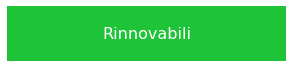

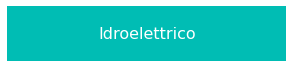

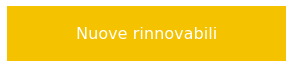

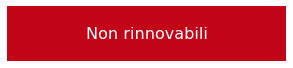

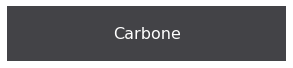

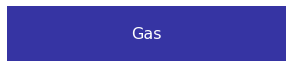

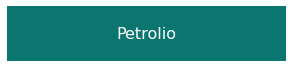

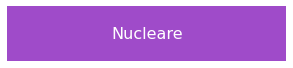

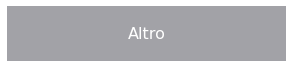

In [7]:
color_palette = {
    'Rinnovabili': '#1EC337',    
    'Idroelettrico': '#00BDB4',    
    'Nuove rinnovabili': '#F5C200',
    'Non rinnovabili': '#C20618', 
    'Carbone': '#434347',       
    'Gas': '#3634a3',           
    'Petrolio': '#0b7570',        
    'Nucleare': '#9F4BC9',     
    'Altro': '#A2A2A7',           
}

for name, color in color_palette.items():
    fig, ax = plt.subplots(1, 1, figsize=(5, 1))
    rect = patches.Rectangle((0, 0), 1, 1, facecolor=color)
    ax.add_patch(rect)
    ax.text(0.5, 0.5, name, va='center', ha='center', fontsize=16, color='white')
    ax.set_ylim(0, 1)
    ax.axis('off')
    plt.show()


### Aree geografiche

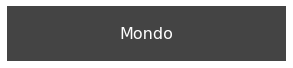

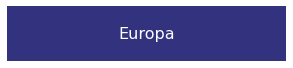

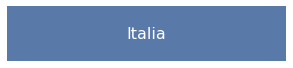

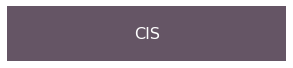

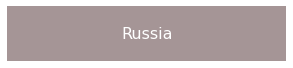

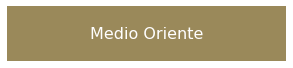

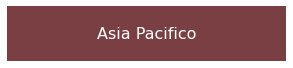

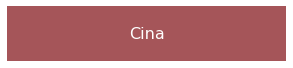

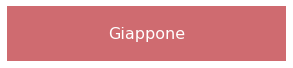

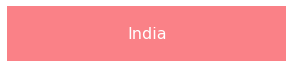

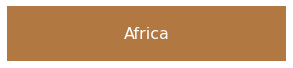

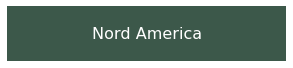

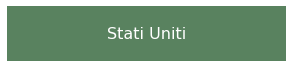

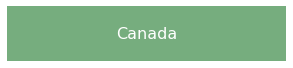

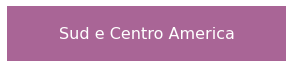

In [8]:
areas_colors = {
    'Mondo': '#444444',
    "Europa": "#32327e", 
    'Italia': '#5979a9',  
    "CIS": "#655565",  
    'Russia': '#A59596',  
    "Medio Oriente": "#9A895A",  
    "Asia Pacifico": "#7a3f42",  
    'Cina': '#A55559',  
    'Giappone': '#cf6b70', 
    'India': '#fa8187',   
    "Africa": "#b27842",
    "Nord America": "#3c584a",
    'Stati Uniti': '#59825f',
    'Canada': '#76ad7e',     
    "Sud e Centro America": "#A96596",    

}

region_colors = {
    "Europe": areas_colors['Europa'],
    "CIS": areas_colors['CIS'],
    "North America": areas_colors['Nord America'],
    "Africa": areas_colors['Africa'],
    "S. & Cent. America": areas_colors['Sud e Centro America'],
    "Middle East": areas_colors['Medio Oriente'],
    "Asia Pacific": areas_colors['Asia Pacifico'],
}

iso_colors = {
    'USA': areas_colors['Stati Uniti'],
    'CHN': areas_colors['Cina'],
    'JPN': areas_colors['Giappone'],
    'RUS': areas_colors['Russia'],
    'IND': areas_colors['India'],
    'CAN': areas_colors['Canada'],
    'ITA': areas_colors['Italia'],
    'EU':  areas_colors['Europa'],
}

country_colors = {
    'Mondo': areas_colors['Mondo'],
    'Europa': areas_colors['Europa'],
    'Stati Uniti': areas_colors['Stati Uniti'],
    'Cina': areas_colors['Cina'],
    'Italia': areas_colors['Italia'],
}

for name, color in areas_colors.items():
    fig, ax = plt.subplots(1, 1, figsize=(5, 1))
    rect = patches.Rectangle((0, 0), 1, 1, facecolor=color)
    ax.add_patch(rect)
    ax.text(0.5, 0.5, name, va='center', ha='center', fontsize=16, color='white')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')
    plt.show()

## Mondo (Produzione di energia elettrica)

### Produzione mondiale di energia elettrica per fonte in assoluto

[Descrizione]

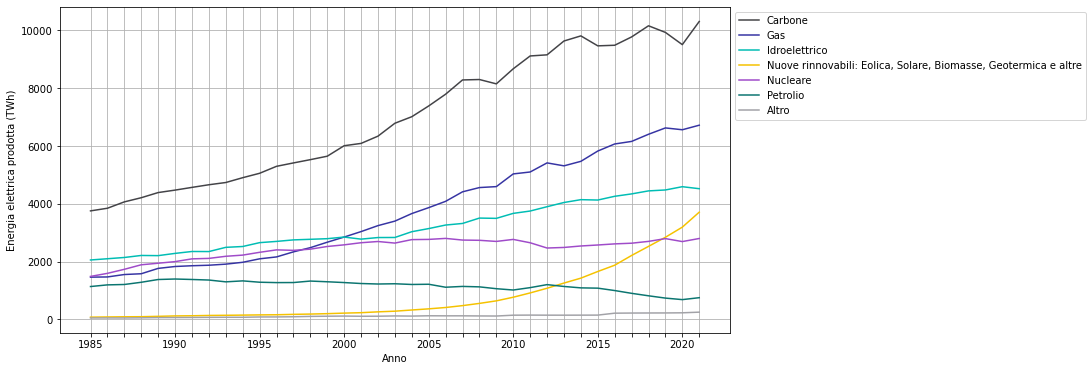

In [9]:
grouped_data = production_data.groupby('Year')[['ElectBy_Coal', 'ElectBy_Gas', 'ElectBy_Hydro', 'ElectBy_Nuclear', 'ElectBy_Oil', 'ElectBy_Other', 'ElectBy_NewRenewables']].sum()

plt.figure(figsize=(12, 6))
plt.plot(grouped_data.index, grouped_data['ElectBy_Coal'], label='Carbone', color=color_palette['Carbone'])
plt.plot(grouped_data.index, grouped_data['ElectBy_Gas'], label='Gas', color=color_palette['Gas'])
plt.plot(grouped_data.index, grouped_data['ElectBy_Hydro'], label='Idroelettrico', color=color_palette['Idroelettrico'])
plt.plot(grouped_data.index, grouped_data['ElectBy_NewRenewables'], label='Nuove rinnovabili: Eolica, Solare, Biomasse, Geotermica e altre', color=color_palette['Nuove rinnovabili'])
plt.plot(grouped_data.index, grouped_data['ElectBy_Nuclear'], label='Nucleare', color=color_palette['Nucleare'])
plt.plot(grouped_data.index, grouped_data['ElectBy_Oil'], label='Petrolio', color=color_palette['Petrolio'])
plt.plot(grouped_data.index, grouped_data['ElectBy_Other'], label='Altro', color=color_palette['Altro'])

plt.xlabel('Anno')
plt.ylabel('Energia elettrica prodotta (TWh)')
plt.legend(bbox_to_anchor=(1, 1))
plt.grid()
start_year = grouped_data.index.min()
end_year = grouped_data.index.max()
x_ticks = plt.xticks(range(start_year, end_year+1, 1))
for i, label in enumerate(plt.gca().xaxis.get_ticklabels()):
    if i % 5 != 0:
        label.set_visible(False)
plt.show()

### Produzione mondiale di energia elettrica per fonte in percentuale

[Descrizione]

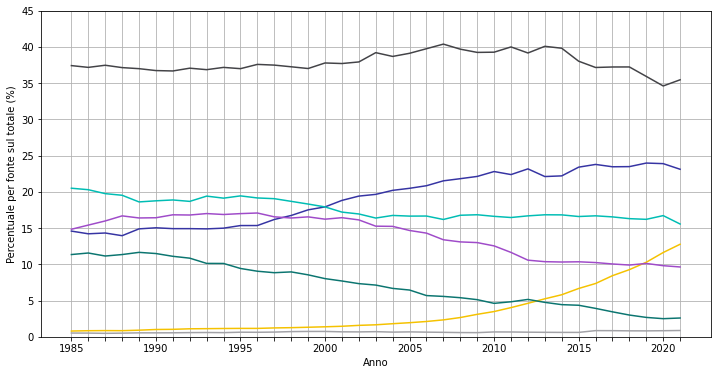

In [10]:
grouped_data = production_data.groupby('Year')[['ElectBy_Coal', 'ElectBy_Gas', 'ElectBy_Hydro', 'ElectBy_Nuclear', 'ElectBy_Oil', 'ElectBy_Other', 'ElectBy_NewRenewables']].sum()
grouped_data_percentage = grouped_data.divide(grouped_data.sum(axis=1), axis=0) * 100

plt.figure(figsize=(12, 6))
plt.plot(grouped_data_percentage.index, grouped_data_percentage['ElectBy_Coal'], label='Carbone', color=color_palette['Carbone'])
plt.plot(grouped_data_percentage.index, grouped_data_percentage['ElectBy_Gas'], label='Gas', color=color_palette['Gas'])
plt.plot(grouped_data_percentage.index, grouped_data_percentage['ElectBy_Hydro'], label='Idroelettrico', color=color_palette['Idroelettrico'])
plt.plot(grouped_data_percentage.index, grouped_data_percentage['ElectBy_NewRenewables'], label='Nuove rinnovabili: Eolica, Solare, Biomasse, Geotermica e altre', color=color_palette['Nuove rinnovabili'])
plt.plot(grouped_data_percentage.index, grouped_data_percentage['ElectBy_Nuclear'], label='Nucleare', color=color_palette['Nucleare'])
plt.plot(grouped_data_percentage.index, grouped_data_percentage['ElectBy_Oil'], label='Petrolio', color=color_palette['Petrolio'])
plt.plot(grouped_data_percentage.index, grouped_data_percentage['ElectBy_Other'], label='Altro', color=color_palette['Altro'])

plt.xlabel('Anno')
plt.ylabel('Percentuale per fonte sul totale (%)')
plt.grid()
plt.ylim(0, 45)
start_year = grouped_data.index.min()
end_year = grouped_data.index.max()
x_ticks = plt.xticks(range(start_year, end_year+1, 1))
for i, label in enumerate(plt.gca().xaxis.get_ticklabels()):
    if i % 5 != 0:
        label.set_visible(False)
plt.yticks(range(0, 46, 5))
plt.show()


[Descrizione]

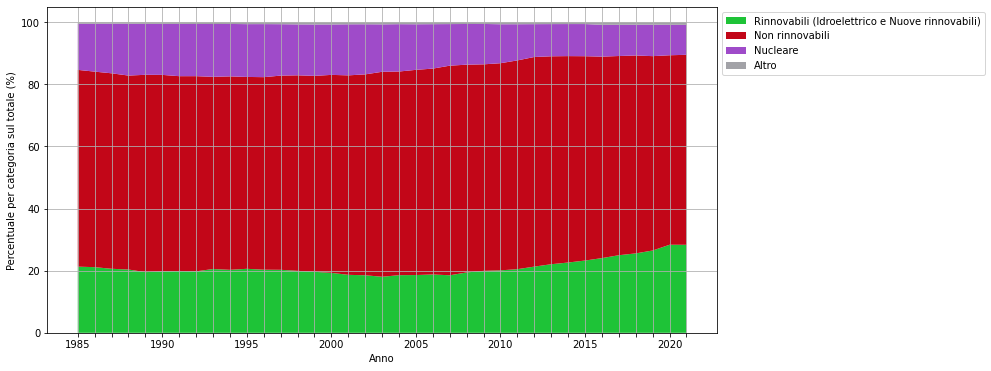

In [11]:
grouped_data = production_data.groupby('Year')[['ElectBy_Coal', 'ElectBy_Gas', 'ElectBy_Hydro', 'ElectBy_Nuclear', 'ElectBy_Oil', 'ElectBy_Other', 'ElectBy_NewRenewables']].sum()
grouped_data_percentage = grouped_data.divide(grouped_data.sum(axis=1), axis=0) * 100

grouped_data_percentage['NotRenewable'] = grouped_data_percentage['ElectBy_Coal'] + grouped_data_percentage['ElectBy_Gas'] + grouped_data_percentage['ElectBy_Oil']
grouped_data_percentage['Nuclear'] = grouped_data_percentage['ElectBy_Nuclear']
grouped_data_percentage['Other'] = grouped_data_percentage['ElectBy_Other']
grouped_data_percentage['Renewable'] = grouped_data_percentage['ElectBy_Hydro'] + grouped_data_percentage['ElectBy_NewRenewables']

plt.figure(figsize=(12, 6))

x = grouped_data_percentage.index
y = [grouped_data_percentage['Renewable'],
     grouped_data_percentage['NotRenewable'],
     grouped_data_percentage['Nuclear'],
     grouped_data_percentage['Other']]

labels = ['Rinnovabili (Idroelettrico e Nuove rinnovabili)', 'Non rinnovabili', 'Nucleare', 'Altro']

colors = [color_palette['Rinnovabili'], color_palette['Non rinnovabili'], color_palette['Nucleare'], color_palette['Altro']]

plt.stackplot(x, y, labels=labels, colors=colors)

plt.xlabel('Anno')
plt.ylabel('Percentuale per categoria sul totale (%)')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.grid()
start_year = grouped_data.index.min()
end_year = grouped_data.index.max()
x_ticks = plt.xticks(range(start_year, end_year+1, 1))
for i, label in enumerate(plt.gca().xaxis.get_ticklabels()):
    if i % 5 != 0:
        label.set_visible(False)
plt.show()


### Produzione mondiale di energia elettrica per area geografica in assoluto

[Descrizione]

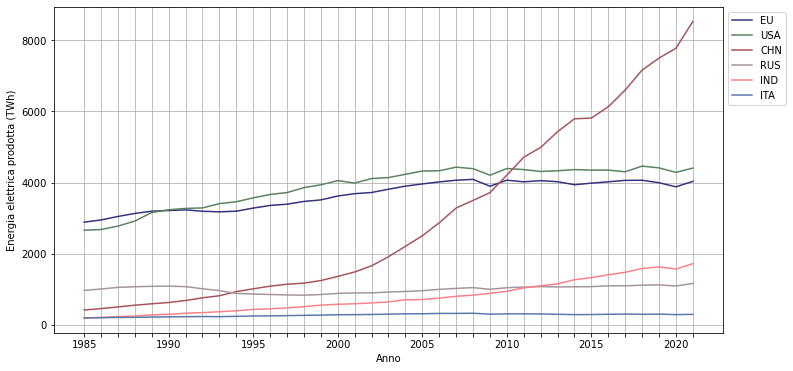

In [12]:
eu_countries = ['Germany', 'Italy', 'Netherlands', 'Poland', 'Spain', 'Turkey', 'Ukraine', 'United Kingdom', 'Other Europe']
eu_data = production_data[production_data['Country'].isin(eu_countries)]

grouped_data = eu_data.groupby('Year')['Total_ElectProd'].sum()

countries = ['USA', 'CHN', 'RUS', 'IND', 'ITA']

plt.figure(figsize=(12, 6))

plt.plot(grouped_data.index, grouped_data, label='EU', color=iso_colors['EU'])

for country in countries:
    data = production_data[production_data['ISO'] == country].groupby('Year')['Total_ElectProd'].sum()
    plt.plot(data.index, data, label=country, color=iso_colors[country])

plt.xlabel('Anno')
plt.ylabel('Energia elettrica prodotta (TWh)')
plt.legend(bbox_to_anchor=(1, 1))
plt.grid()
start_year = grouped_data.index.min()
end_year = grouped_data.index.max()
x_ticks = plt.xticks(range(start_year, end_year+1, 1))
for i, label in enumerate(plt.gca().xaxis.get_ticklabels()):
    if i % 5 != 0:
        label.set_visible(False)
plt.show()

## Europa (Produzione di energia elettrica)

### Produzione europea di energia elettrica per fonte in assoluto

[Descrizione]

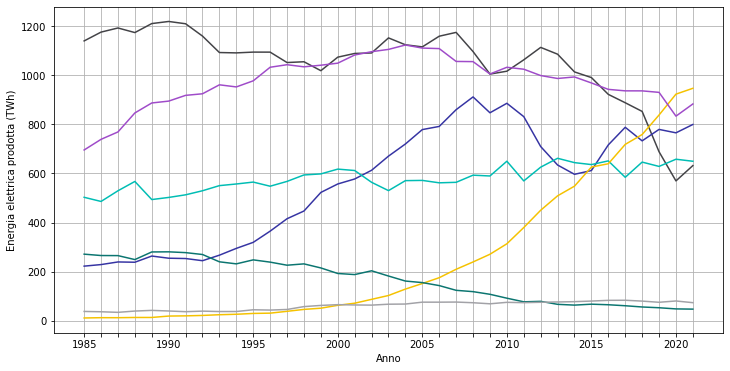

In [13]:
grouped_data = eu_data.groupby('Year')[['ElectBy_Coal', 'ElectBy_Gas', 'ElectBy_Hydro', 'ElectBy_Nuclear', 'ElectBy_Oil', 'ElectBy_Other', 'ElectBy_NewRenewables']].sum()

plt.figure(figsize=(12, 6))
plt.plot(grouped_data.index, grouped_data['ElectBy_Coal'], label='Carbone', color=color_palette['Carbone'])
plt.plot(grouped_data.index, grouped_data['ElectBy_Gas'], label='Gas', color=color_palette['Gas'])
plt.plot(grouped_data.index, grouped_data['ElectBy_Hydro'], label='Idroelettrico', color=color_palette['Idroelettrico'])
plt.plot(grouped_data.index, grouped_data['ElectBy_NewRenewables'], label='Nuove rinnovabili: Eolica, Solare, Biomasse, Geotermica e altre', color=color_palette['Nuove rinnovabili'])
plt.plot(grouped_data.index, grouped_data['ElectBy_Nuclear'], label='Nucleare', color=color_palette['Nucleare'])
plt.plot(grouped_data.index, grouped_data['ElectBy_Oil'], label='Petrolio', color=color_palette['Petrolio'])
plt.plot(grouped_data.index, grouped_data['ElectBy_Other'], label='Altro', color=color_palette['Altro'])

plt.xlabel('Anno')
plt.ylabel('Energia elettrica prodotta (TWh)')
plt.grid()
start_year = grouped_data.index.min()
end_year = grouped_data.index.max()
x_ticks = plt.xticks(range(start_year, end_year+1, 1))
for i, label in enumerate(plt.gca().xaxis.get_ticklabels()):
    if i % 5 != 0:
        label.set_visible(False)
plt.show()


### Produzione europea di energia elettrica per fonte in percentuale

[Descrizione]

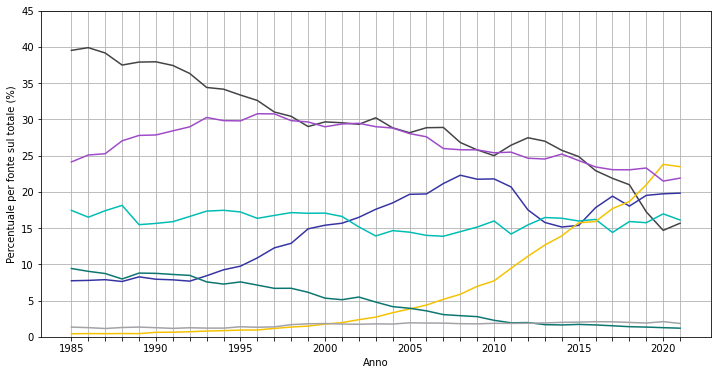

In [14]:
grouped_data = eu_data.groupby('Year')[['ElectBy_Coal', 'ElectBy_Gas', 'ElectBy_Hydro', 'ElectBy_Nuclear', 'ElectBy_Oil', 'ElectBy_Other', 'ElectBy_NewRenewables']].sum()
grouped_data_percentage = grouped_data.divide(grouped_data.sum(axis=1), axis=0) * 100

plt.figure(figsize=(12, 6))
plt.plot(grouped_data_percentage.index, grouped_data_percentage['ElectBy_Coal'], label='Carbone', color=color_palette['Carbone'])
plt.plot(grouped_data_percentage.index, grouped_data_percentage['ElectBy_Gas'], label='Gas', color=color_palette['Gas'])
plt.plot(grouped_data_percentage.index, grouped_data_percentage['ElectBy_Hydro'], label='Idroelettrico', color=color_palette['Idroelettrico'])
plt.plot(grouped_data_percentage.index, grouped_data_percentage['ElectBy_NewRenewables'], label='Nuove rinnovabili: Eolica, Solare, Biomasse, Geotermica e altre', color=color_palette['Nuove rinnovabili'])
plt.plot(grouped_data_percentage.index, grouped_data_percentage['ElectBy_Nuclear'], label='Nucleare', color=color_palette['Nucleare'])
plt.plot(grouped_data_percentage.index, grouped_data_percentage['ElectBy_Oil'], label='Petrolio', color=color_palette['Petrolio'])
plt.plot(grouped_data_percentage.index, grouped_data_percentage['ElectBy_Other'], label='Altro', color=color_palette['Altro'])

plt.xlabel('Anno')
plt.ylabel('Percentuale per fonte sul totale (%)')
plt.grid()
plt.ylim(0, 45)
start_year = grouped_data.index.min()
end_year = grouped_data.index.max()
x_ticks = plt.xticks(range(start_year, end_year+1, 1))
for i, label in enumerate(plt.gca().xaxis.get_ticklabels()):
    if i % 5 != 0:
        label.set_visible(False)
plt.yticks(range(0, 46, 5))
plt.show()

[Descrizione]

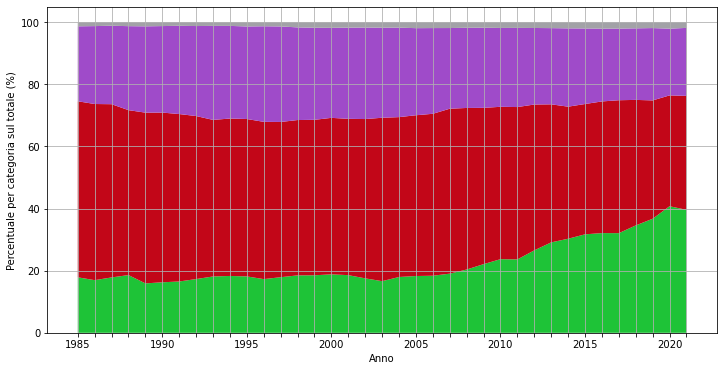

In [15]:
grouped_data = eu_data.groupby('Year')[['ElectBy_Coal', 'ElectBy_Gas', 'ElectBy_Hydro', 'ElectBy_Nuclear', 'ElectBy_Oil', 'ElectBy_Other', 'ElectBy_NewRenewables']].sum()
grouped_data_percentage = grouped_data.divide(grouped_data.sum(axis=1), axis=0) * 100

grouped_data_percentage['NotRenewable'] = grouped_data_percentage['ElectBy_Coal'] + grouped_data_percentage['ElectBy_Gas'] + grouped_data_percentage['ElectBy_Oil']
grouped_data_percentage['Nuclear'] = grouped_data_percentage['ElectBy_Nuclear']
grouped_data_percentage['Other'] = grouped_data_percentage['ElectBy_Other']
grouped_data_percentage['Renewable'] = grouped_data_percentage['ElectBy_Hydro'] + grouped_data_percentage['ElectBy_NewRenewables']

plt.figure(figsize=(12, 6))

x = grouped_data_percentage.index
y = [grouped_data_percentage['Renewable'],
     grouped_data_percentage['NotRenewable'],
     grouped_data_percentage['Nuclear'],
     grouped_data_percentage['Other']]

labels = ['Rinnovabili (Idroelettrico e Nuove rinnovabili)', 'Non rinnovabili', 'Nucleare', 'Altro']

colors = [color_palette['Rinnovabili'], color_palette['Non rinnovabili'], color_palette['Nucleare'], color_palette['Altro']]

plt.stackplot(x, y, labels=labels, colors=colors)

plt.xlabel('Anno')
plt.ylabel('Percentuale per categoria sul totale (%)')
plt.grid()
start_year = grouped_data.index.min()
end_year = grouped_data.index.max()
x_ticks = plt.xticks(range(start_year, end_year+1, 1))
for i, label in enumerate(plt.gca().xaxis.get_ticklabels()):
    if i % 5 != 0:
        label.set_visible(False)
plt.show()


### Energia elettrica prodotta per stato in assoluto negli ultimi 10 anni

[Descrizione]

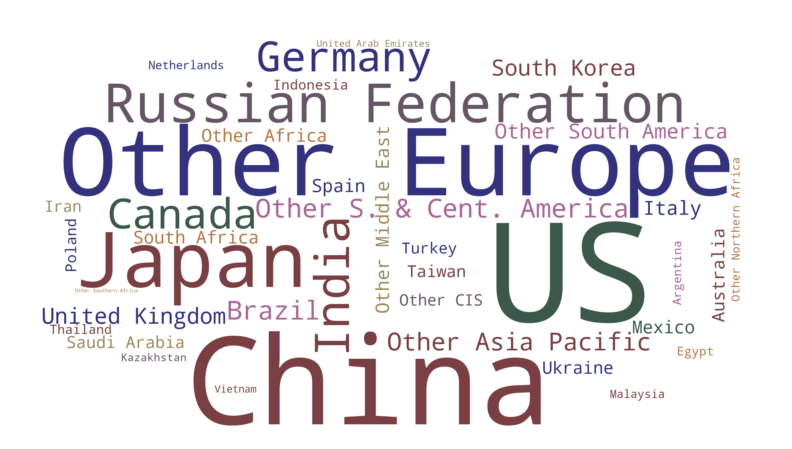

In [16]:
grouped_data = production_data.groupby('Country')['Total_ElectProd'].sum().reset_index()

wordcloud_text = []
for index, row in grouped_data.iterrows():
    country = row['Country']
    quantity = int(row['Total_ElectProd'])
    wordcloud_text.extend([country] * quantity)
    
word_frequencies = dict(Counter(wordcloud_text))

world_mask = np.array(Image.open("images/world-map.png"))

merged_data_2021 = merged_data.query('Year == 2021')
country_to_region = merged_data_2021.groupby('Country')['Region'].first().to_dict()
default_color = "#808080"  
country_color = {country: region_colors.get(region, default_color) for country, region in country_to_region.items()}

def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return country_color.get(word, default_color)

wordcloud = WordCloud(width=800, height=400, background_color='white', mask=world_mask, color_func=color_func).generate_from_frequencies(word_frequencies)

plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Italia (Produzione di energia elettrica)

### Produzione di energia elettrica per fonte in assoluto negli ultimi 10 anni

[Descrizione]

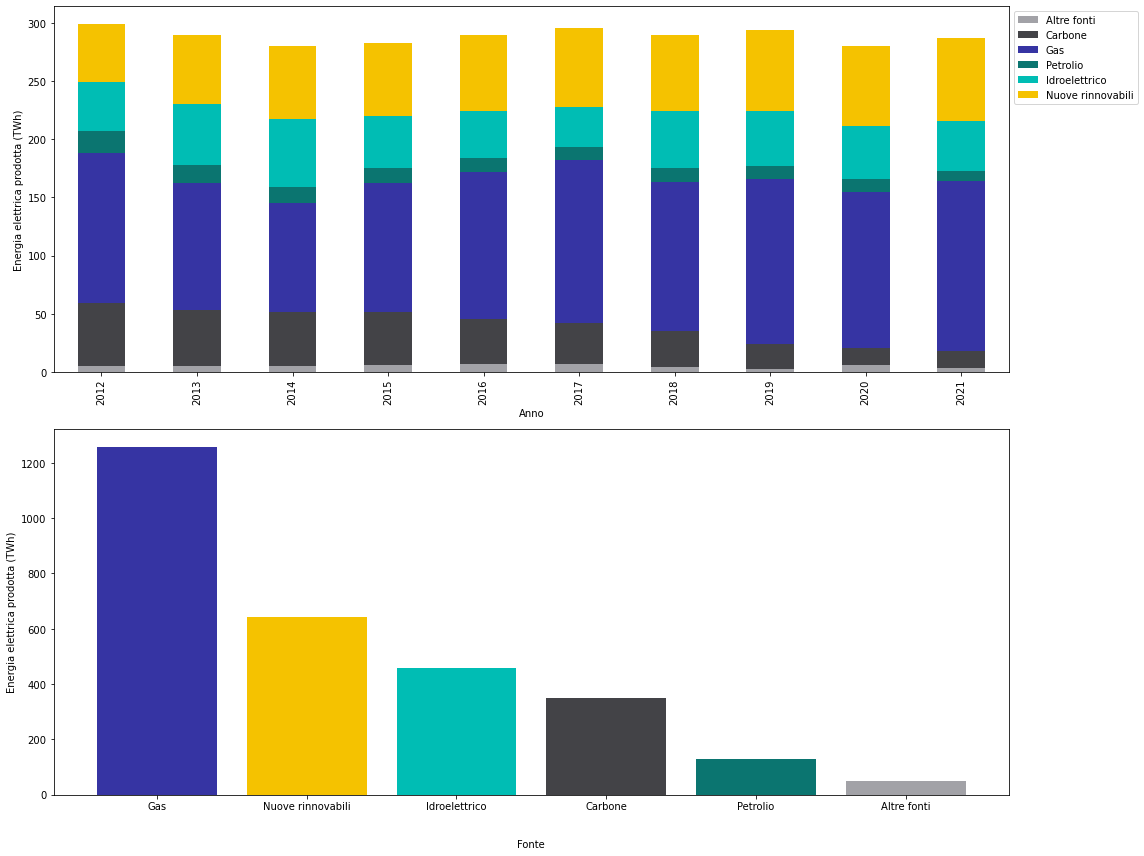

In [17]:
italy_data = production_data[(production_data['Country'] == 'Italy') & (production_data['Year'] > production_data['Year'].max() - 10)]

energy_sources = ['ElectBy_Other', 'ElectBy_Coal', 'ElectBy_Gas', 'ElectBy_Oil', 'ElectBy_Hydro', 'ElectBy_NewRenewables']
italy_energy_production = italy_data.set_index('Year')[energy_sources]

italy_energy_totals = italy_energy_production.sum().reset_index()
italy_energy_totals.columns = ['Fonte di energia', 'Produzione totale']

italy_energy_totals = italy_energy_totals.sort_values('Produzione totale', ascending=False)

fig, axs = plt.subplots(2, 1, figsize=(16, 12))

italian_names = {
    'ElectBy_Other': 'Altre fonti',
    'ElectBy_Coal': 'Carbone',
    'ElectBy_Gas': 'Gas',
    'ElectBy_Oil': 'Petrolio',
    'ElectBy_Hydro': 'Idroelettrico',
    'ElectBy_NewRenewables': 'Nuove rinnovabili'
}

italy_energy_production = italy_energy_production.rename(columns=italian_names)
italy_energy_totals['Fonte di energia'] = italy_energy_totals['Fonte di energia'].replace(italian_names)

color_map = {
    'Altre fonti': color_palette['Altro'],
    'Carbone': color_palette['Carbone'],
    'Gas': color_palette['Gas'],
    'Petrolio': color_palette['Petrolio'],
    'Idroelettrico': color_palette['Idroelettrico'],
    'Nuove rinnovabili': color_palette['Nuove rinnovabili']
}

italy_energy_production.plot(kind='bar', stacked=True, ax=axs[0], color=[color_map[name] for name in italy_energy_production.columns])
axs[0].set_xlabel('Anno')
axs[0].set_ylabel('Energia elettrica prodotta (TWh)')
axs[0].legend(loc='upper left', bbox_to_anchor=(1, 1))
axs[1].set_xlabel('\n\nFonte')
axs[1].bar(italy_energy_totals['Fonte di energia'], italy_energy_totals['Produzione totale'], color=[color_map[name] for name in italy_energy_totals['Fonte di energia']])
axs[1].set_ylabel('Energia elettrica prodotta (TWh)')

plt.tight_layout()
plt.show()


### Produzione di energia elettrica per categoria in percentuale negli ultimi 10 anni

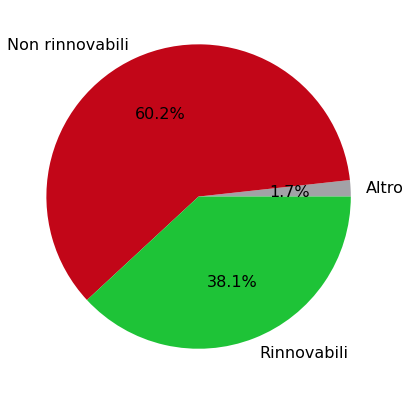

In [18]:
plt.rcParams['font.size'] = 16

italy_energy_categories = italy_energy_production.sum().rename({
    'Carbone': 'Non rinnovabili',
    'Gas': 'Non rinnovabili',
    'Petrolio': 'Non rinnovabili',
    'Idroelettrico': 'Rinnovabili',
    'Nuove rinnovabili': 'Rinnovabili',
    'Altre fonti': 'Altro'
}).groupby(level=0).sum()

italy_energy_categories = italy_energy_categories.loc[italy_energy_categories != 0]

italy_energy_percentages = italy_energy_categories / italy_energy_categories.sum() * 100

pie_colors = [color_palette[cat] for cat in italy_energy_percentages.index]

plt.figure(figsize=(10, 7))
plt.pie(italy_energy_percentages, labels=italy_energy_percentages.index, autopct='%1.1f%%', colors=pie_colors)
plt.show()

plt.rcParams['font.size'] = 10

## Confronto

### Confronto percentuali per categoria per Mondo, Unione Europea, Italia, Stati Uniti e Cina

[Descrizione]

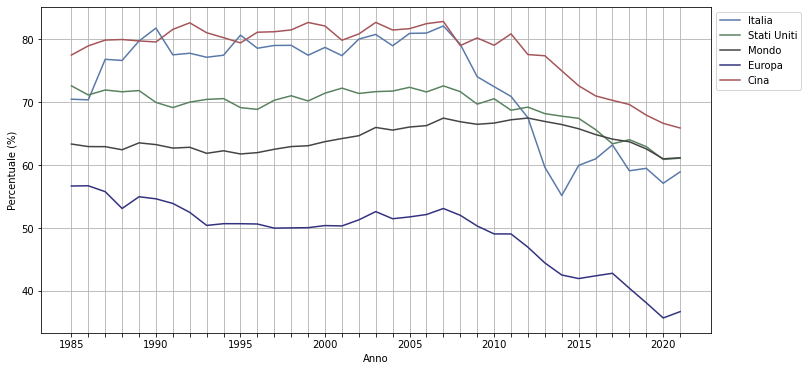

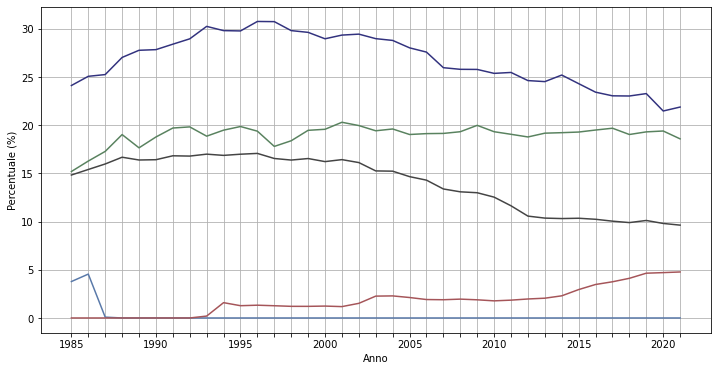

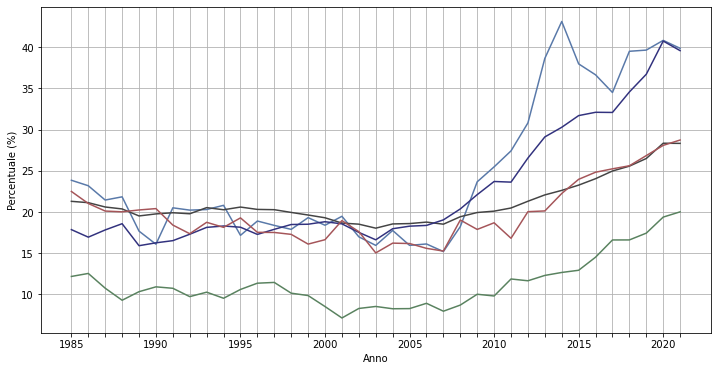

In [19]:
ita_data = merged_data[merged_data['ISO'] == 'ITA']
usa_data = merged_data[merged_data['ISO'] == 'USA']
china_data = merged_data[merged_data['ISO'] == 'CHN']
world_data = merged_data

countries_data = {
    'Italia': ita_data,
    'Stati Uniti': usa_data,
    'Mondo': world_data,
    'Europa': eu_data,
    'Cina': china_data
}

energy_categories = {
    'Non rinnovabile': ['ElectBy_Coal', 'ElectBy_Gas', 'ElectBy_Oil'],
    'Nucleare': ['ElectBy_Nuclear'],
    'Rinnovabile': ['ElectBy_Hydro', 'ElectBy_NewRenewables']
}

energy_categories_it = {
    'Non rinnovabile': 'non rinnovabile',
    'Nucleare': 'nucleare',
    'Rinnovabile': 'rinnovabile'
}

show_legend = True

for energy_category, energy_sources_columns in energy_categories.items():

    plt.figure(figsize=(12, 6))

    for country, country_data in countries_data.items():

        country_energy_percentage = country_data.groupby('Year')[energy_sources_columns].sum().sum(axis=1) / country_data.groupby('Year')['Total_ElectProd'].sum() * 100

        plt.plot(country_energy_percentage.index, country_energy_percentage, label=country, color=country_colors[country])

    start_year = int(country_energy_percentage.index.min())
    end_year = int(country_energy_percentage.index.max())
    
    plt.xticks(range(start_year, end_year+1, 1))
    for i, label in enumerate(plt.gca().xaxis.get_ticklabels()):
        if i % 5 != 0:
            label.set_visible(False)

    plt.xlabel('Anno')
    plt.ylabel(f'Percentuale (%)')
    if show_legend:
        plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
        show_legend = False
    plt.grid(True)
    plt.show()

## Emissioni di CO2 per settore in percentuale negli ultimi 10 anni

[Descrizione]

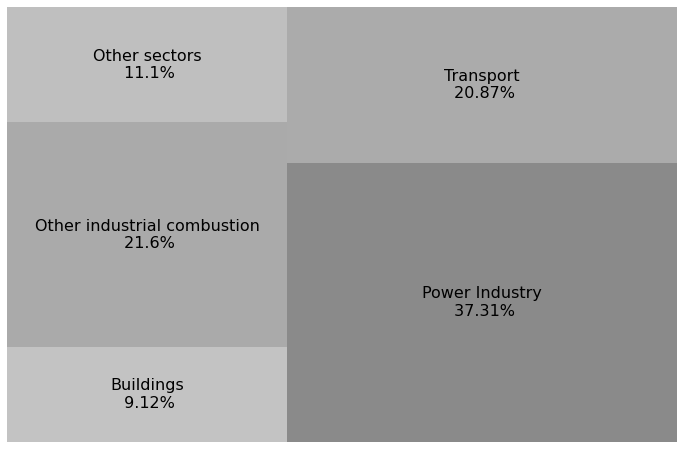

In [20]:
plt.rcParams['font.size'] = 16

emission_data['Year'] = emission_data['Year'].astype(int)

last_10_years = range(emission_data['Year'].max() - 10, emission_data['Year'].max() + 1)
data_last_10_years = emission_data[emission_data['Year'].isin(last_10_years)]

emissions_per_sector = data_last_10_years.groupby('Sector')['Emissions'].sum().reset_index()

total_emissions = data_last_10_years['Emissions'].sum()
emissions_per_sector['Percentage'] = emissions_per_sector['Emissions'] / total_emissions * 100

brightness = 50

def get_grey_scale_color(percentage):
    grey_scale_color = str(int((100 - percentage) * 2.55))
    grey_scale_color = max(0, min(int(grey_scale_color) - brightness, 255))
    return '#' + format(grey_scale_color, '02x') * 3

fig, ax = plt.subplots(figsize=(12,8))
labels = emissions_per_sector.apply(lambda x: str(x['Sector']) + "\n " + str(round(x['Percentage'], 2)) + "%", axis=1)
colors = emissions_per_sector['Percentage'].apply(get_grey_scale_color)
plt.axis('off')
squarify.plot(sizes=emissions_per_sector['Percentage'], label=labels, alpha=.8, color=colors, ax=ax)
plt.show()

plt.rcParams['font.size'] = 10

### Box plot per le emissioni della power industry (1991, 2001, 2011, 2021)

[Descrizione]

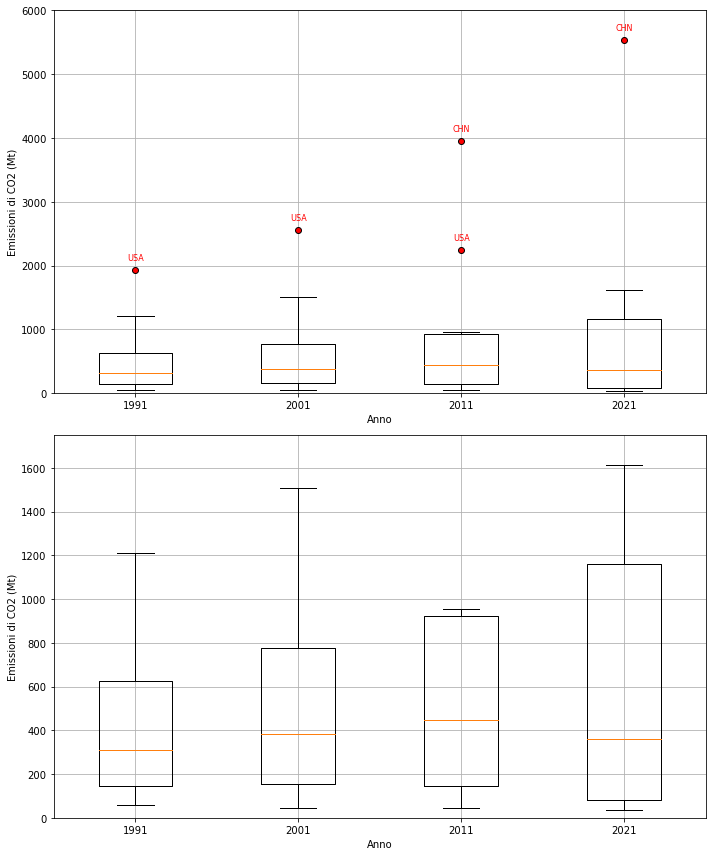

In [21]:
selected_countries = ['ITA', 'USA', 'CHN', 'JPN', 'DEU', 'GBR', 'FRA', 'CAN', 'IND', 'RUS']

selected_data = merged_data[(merged_data['ISO'].isin(selected_countries)) & (merged_data['Year'].isin([1991, 2001, 2011, 2021]))]

data_per_year = {}

for year in [1991, 2001, 2011, 2021]:
    year_data = selected_data[selected_data['Year'] == year]
    data_per_year[year] = year_data['CO2By_ElectProd'].tolist()

fig, axs = plt.subplots(2, 1, figsize=(10, 12)) 

box_plot = axs[0].boxplot(data_per_year.values(), flierprops={'marker': 'o', 'markerfacecolor': 'red', 'markersize': 6})
axs[0].set_ylim([0, 6000])
axs[0].set_xticks(range(1, len(data_per_year) + 1))
axs[0].set_xticklabels(data_per_year.keys())
axs[0].set_ylabel('Emissioni di CO2 (Mt)')
axs[0].set_xlabel('Anno')
axs[0].grid(True)

box_plot = axs[1].boxplot(data_per_year.values(), flierprops={'marker': 'o', 'markerfacecolor': 'red', 'markersize': 6})
axs[1].set_ylim([0, 1750])
axs[1].set_xticks(range(1, len(data_per_year) + 1))
axs[1].set_xticklabels(data_per_year.keys())
axs[1].set_ylabel('Emissioni di CO2 (Mt)')
axs[1].set_xlabel('Anno')
axs[1].grid(True)

for idx in range(2):
    outliers = box_plot['fliers']
    for i, outlier in enumerate(outliers):
        x = int(outlier.get_xdata()[0])
        y_values = outlier.get_ydata()
        outlier_countries = []
        for y in y_values:
            outlier_country = None
            for year, data in data_per_year.items():
                if y in data:
                    year_data = selected_data[selected_data['Year'] == year]
                    outlier_country = year_data[year_data['CO2By_ElectProd'] == y]['ISO'].iloc[0]
                    break
            if outlier_country:
                outlier_countries.append(outlier_country)
        if outlier_countries:
            for j, country in enumerate(outlier_countries):
                axs[idx].annotate(country, (x, y_values[j]), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=8, color='red')

plt.tight_layout()
plt.show()

### Emissioni di CO2 della power industry per Europa, paesi selezionati e Mondo 

[Descrizione]

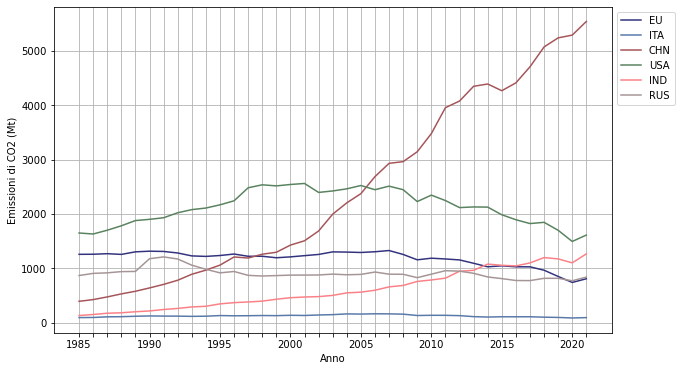

In [22]:
iso3_selected_countries = ['ITA', 'CHN', 'USA', 'IND', 'RUS']
iso3_eu = ['BEL', 'BGR', 'CZE', 'DNK', 'DEU', 'EST', 'IRL', 'GRC', 'ESP', 'FRA', 'HRV', 'ITA', 'CYP', 'LVA', 'LTU', 'LUX', 'HUN', 'MLT', 'NLD', 'AUT', 'POL', 'PRT', 'ROU', 'SVN', 'SVK', 'FIN', 'SWE']

selected_merged_data = merged_data[merged_data['ISO'].isin(iso3_selected_countries + iso3_eu)]

plt.figure(figsize=(10, 6))

europe_data = selected_merged_data[selected_merged_data['ISO'].isin(iso3_eu)]
europe_aggregated = europe_data.groupby('Year')['CO2By_ElectProd'].sum()
plt.plot(europe_aggregated.index, europe_aggregated.values, label='EU', color=iso_colors['EU'])

for country in iso3_selected_countries:
    country_data = selected_merged_data[selected_merged_data['ISO'] == country]
    plt.plot(country_data['Year'], country_data['CO2By_ElectProd'], label=country, color=iso_colors[country]) 
    
start_year = int(selected_merged_data['Year'].min())
end_year = int(selected_merged_data['Year'].max())
    
plt.xticks(range(start_year, end_year+1, 1))
for i, label in enumerate(plt.gca().xaxis.get_ticklabels()):
    if i % 5 != 0:
        label.set_visible(False)

plt.xlabel('Anno')
plt.ylabel('Emissioni di CO2 (Mt)')
plt.legend(bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()


### Emissioni di CO2 della power industry nel 2021

[Descrizione]

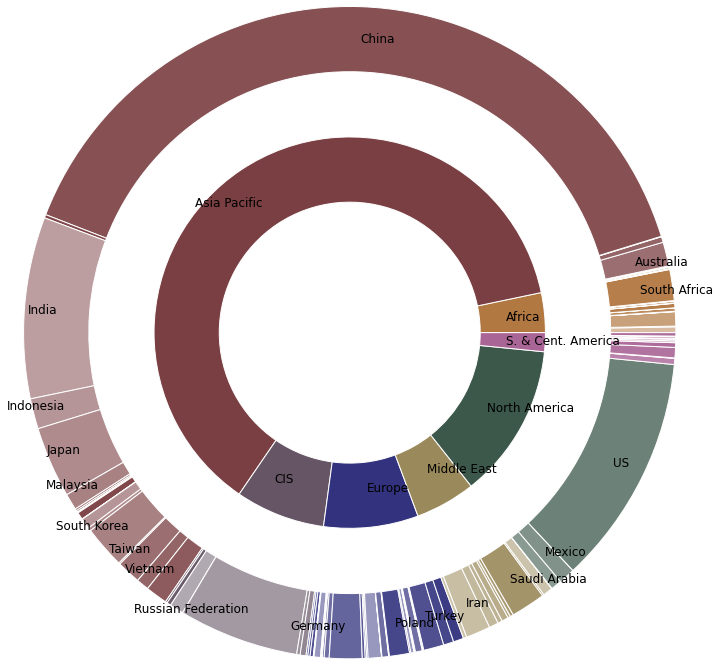

In [23]:
merged_data_2021 = merged_data.query('Year == 2021')

attribute = 'CO2By_ElectProd';

world_co2 = merged_data_2021[attribute].sum()

regions_data = merged_data_2021.groupby('Region')[attribute].sum().reset_index()
regions_names = regions_data['Region'].tolist()
regions_size = regions_data[attribute].tolist()

countries_data = merged_data_2021.groupby(['Region', 'Country'])[attribute].sum().reset_index()
countries_names = countries_data['Country'].tolist()
countries_size = countries_data[attribute].tolist()

label_threshold = 0.0075

color_map_regions = {region: region_colors[region] for region in regions_names}

color_map_countries = {}
for i, row in countries_data.iterrows():
    base_color = mcolors.to_rgba(color_map_regions[row['Region']])
    country_color = base_color[:3] + (0.5 + ((i % 10) * 0.05),)
    color_map_countries[row['Country']] = country_color
    
countries_labels = [None if size/world_co2 < label_threshold else name for name, size in zip(countries_names, countries_size)]

fig, ax = plt.subplots(figsize=(6, 6))
ax.axis('equal')

region_colors = [color_map_regions[region] for region in regions_names]
mypie2, _ = ax.pie(regions_size, radius=1.5, labels=regions_names, labeldistance=0.8, colors=region_colors, textprops={'fontsize': 12})
plt.setp(mypie2, width=0.5, edgecolor='white')

country_colors = [color_map_countries[country] for country in countries_names]
mypie3, _ = ax.pie(countries_size, radius=2.5, labels=countries_labels, labeldistance=0.9, colors=country_colors, textprops={'fontsize': 12})
plt.setp(mypie3, width=0.5, edgecolor='white')

plt.margins(0, 0)
plt.show()

### Relazione tra energia elettrica prodotta ed emissioni della power industry 

[Descrizione]

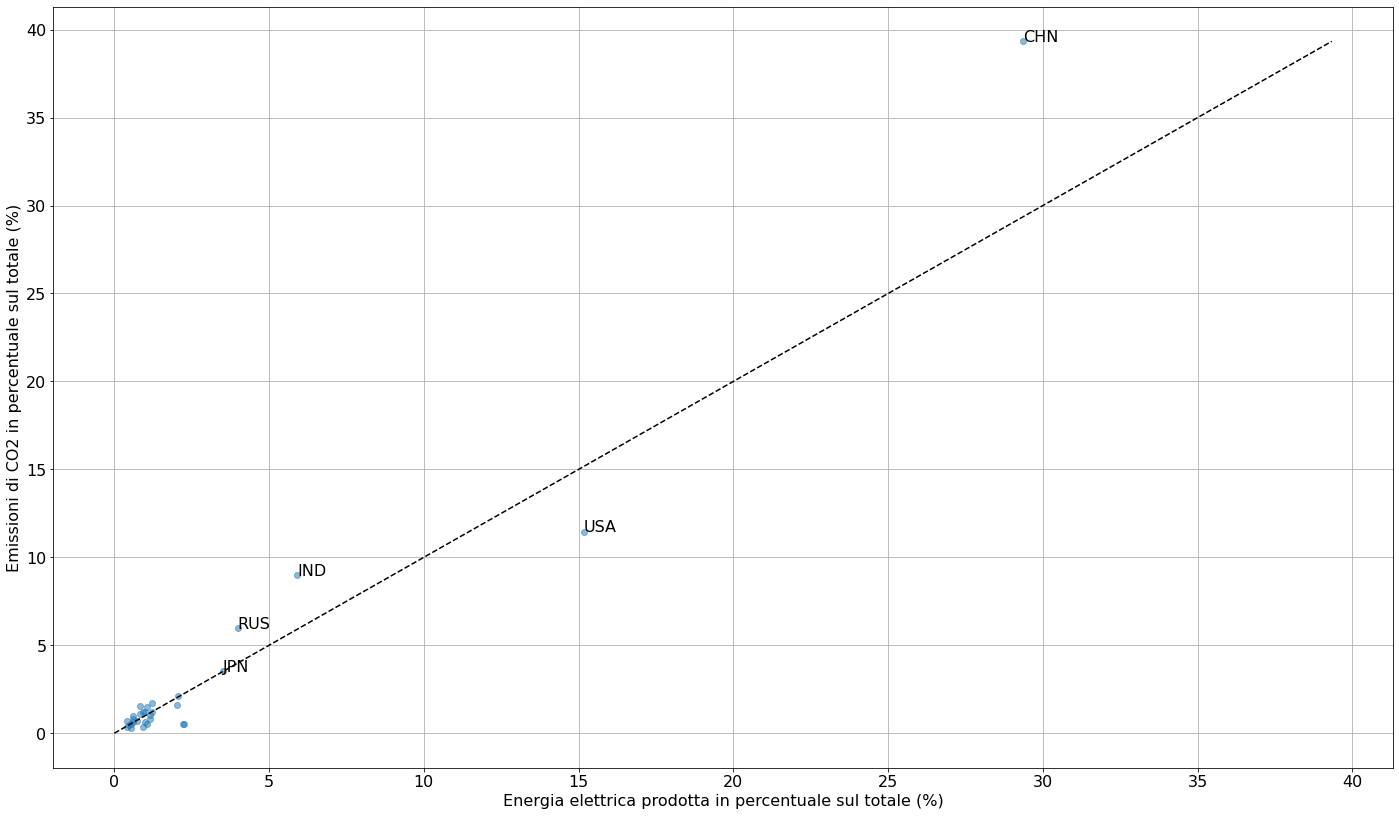

In [24]:
merged_data_2021 = merged_data[merged_data['Year'] == 2021]
df_combined = merged_data_2021[['ISO', 'Total_ElectProd', 'CO2By_ElectProd']]

df_combined = df_combined.dropna()

total_elect_prod_2021 = merged_data_2021['Total_ElectProd'].sum()
total_co2_emission_2021 = merged_data_2021['CO2By_ElectProd'].sum()

df_combined['Total_ElectProd_Percent'] = (df_combined['Total_ElectProd'] / total_elect_prod_2021) * 100
df_combined['CO2By_ElectProd_Percent'] = (df_combined['CO2By_ElectProd'] / total_co2_emission_2021) * 100

plt.rcParams['font.size'] = 16

plt.figure(figsize=(24, 14))
plt.scatter(df_combined['Total_ElectProd_Percent'], df_combined['CO2By_ElectProd_Percent'], alpha=0.5)

iso3_countries_of_interest = ['CHN', 'IND', 'USA', 'RUS', 'JPN']

df_selected_countries = df_combined[df_combined['ISO'].isin(iso3_countries_of_interest)]
for i in range(len(df_selected_countries)):
    iso3_country = df_selected_countries['ISO'].iloc[i]
    x = df_selected_countries['Total_ElectProd_Percent'].iloc[i]
    y = df_selected_countries['CO2By_ElectProd_Percent'].iloc[i]
    plt.annotate(iso3_country, (x, y))

plt.xlabel('Energia elettrica prodotta in percentuale sul totale (%)')
plt.ylabel('Emissioni di CO2 in percentuale sul totale (%)')

max_value = max(df_combined['Total_ElectProd_Percent'].max(), df_combined['CO2By_ElectProd_Percent'].max())
plt.plot([0, max_value], [0, max_value], 'k--')

plt.grid(True)

plt.show()

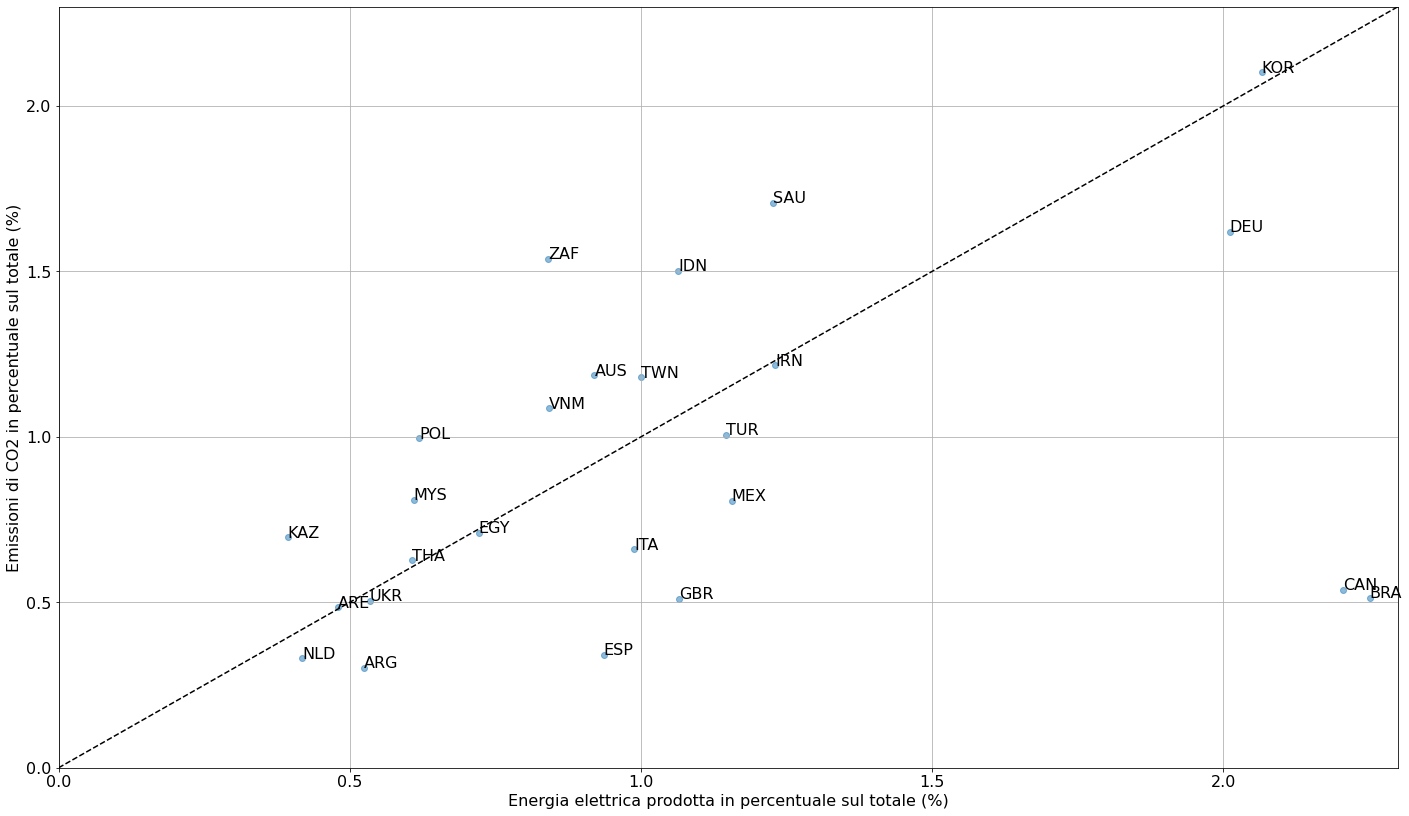

In [25]:
plt.figure(figsize=(24, 14))
plt.scatter(df_combined['Total_ElectProd_Percent'], df_combined['CO2By_ElectProd_Percent'], alpha=0.5)

iso3_countries_of_interest = merged_data_2021['ISO'].unique()
df_selected_countries = df_combined[df_combined['ISO'].isin(iso3_countries_of_interest)]
for i in range(len(df_selected_countries)):
    iso3_country = df_selected_countries['ISO'].iloc[i]
    x = df_selected_countries['Total_ElectProd_Percent'].iloc[i]
    y = df_selected_countries['CO2By_ElectProd_Percent'].iloc[i]
    plt.annotate(iso3_country, (x, y))

plt.xlabel('Energia elettrica prodotta in percentuale sul totale (%)')
plt.ylabel('Emissioni di CO2 in percentuale sul totale (%)')

max_value = max(df_combined['Total_ElectProd_Percent'].max(), df_combined['CO2By_ElectProd_Percent'].max())
plt.plot([0, max_value], [0, max_value], 'k--')

plt.xlim([0, 2.3])
plt.ylim([0, 2.3])

plt.grid(True)

plt.show()

plt.rcParams['font.size'] = 10